In [1]:
#!pip install -r requirements.txt

In [3]:
print("All required packages are installed.")

All required packages are installed.


In [18]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import cv2
import numpy as np

sys.path.append(os.getcwd())

from src.image_loader import ImageLoader
from src.preprocessor import ImagePreprocessor
from src.feature_extractor import FeatureExtractor
from src.DiscolorationVisualizer import DiscolorationVisualizer
from src.classifier import LeukemiaClassifier

In [15]:
preprocessor = ImagePreprocessor()
extractor = FeatureExtractor()
visualizer = DiscolorationVisualizer()
classifier = LeukemiaClassifier()

In [7]:
def process_dataset(category_name):
    """
    Przetwarza zdjęcia z folderu data/{category_name} 
    i zapisuje wyniki do output/{category_name}_processed.
    Zwraca DataFrame z wynikami dla tej kategorii.
    """
    
    input_dir = os.path.join("data", category_name)
    output_dir = os.path.join("output", f"{category_name}_processed")
    
    print(f"\n--- Rozpoczynam analizę kategorii: {category_name.upper()} ---")
    print(f"Wejście: {input_dir}")
    print(f"Wyjście: {output_dir}")
    
    loader = ImageLoader(input_dir)
    category_results = []
    
    for filename, img in loader.load_images():
        
        gray = preprocessor.to_gray(img)
        
        enhanced = preprocessor.enhance_contrast_clahe(gray) 
        
        mask = preprocessor.generate_mask_entropy(enhanced)
        
        features, contour = extractor.extract(img, mask)
        
        if features:
            features['filename'] = filename
            features['label'] = category_name 
            
            category_results.append(features)
            heatmap = visualizer.create_heatmap(img, mask)
            
            viz_img = img.copy()
            cv2.drawContours(viz_img, [contour], -1, (0, 255, 0), 2)
            mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
            combined = np.hstack([img, mask_3ch, heatmap])
            
            loader.save_image(output_dir, filename, mask, suffix="mask")
            loader.save_image(output_dir, filename, viz_img, suffix="result")
            loader.save_image(output_dir, filename, combined, suffix="analysis")
            
    df = pd.DataFrame(category_results)
    print(f"Zakończono {category_name}. Przetworzono {len(df)} obrazów.")
    return df

In [8]:
df_healthy = process_dataset("healthy")

df_cancer = process_dataset("cancer")
df_all = pd.concat([df_healthy, df_cancer], ignore_index=True)


--- Rozpoczynam analizę kategorii: HEALTHY ---
Wejście: data\healthy
Wyjście: output\healthy_processed
Zakończono healthy. Przetworzono 65 obrazów.

--- Rozpoczynam analizę kategorii: CANCER ---
Wejście: data\cancer
Wyjście: output\cancer_processed
Zakończono cancer. Przetworzono 49 obrazów.


### Data analysis

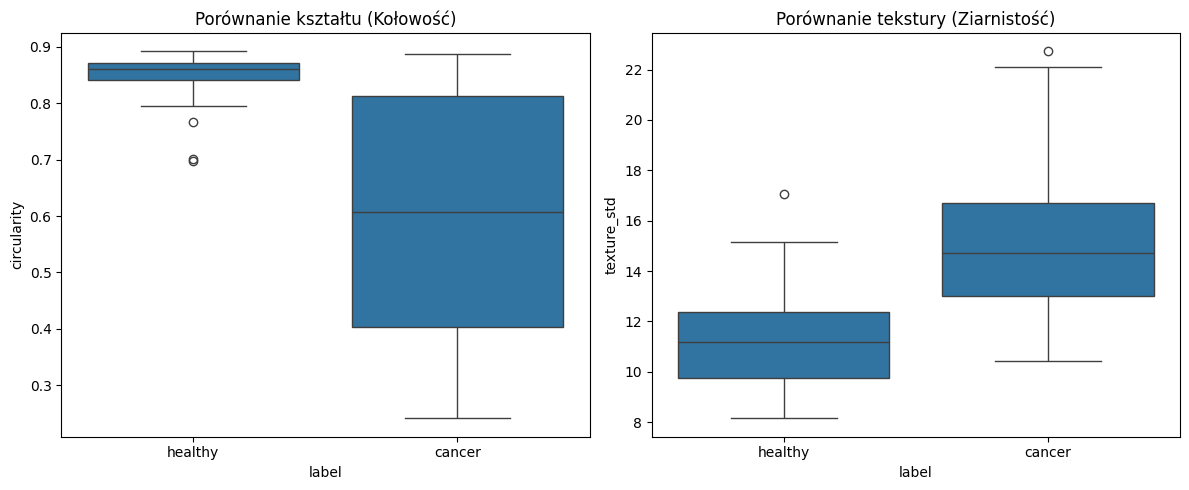

In [9]:
if not df_all.empty:
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.boxplot(x='label', y='circularity', data=df_all)
    plt.title("Porównanie kształtu (Kołowość)")
    
    plt.subplot(1, 2, 2)
    sns.boxplot(x='label', y='texture_std', data=df_all)
    plt.title("Porównanie tekstury (Ziarnistość)")
    
    plt.tight_layout()
    plt.show()

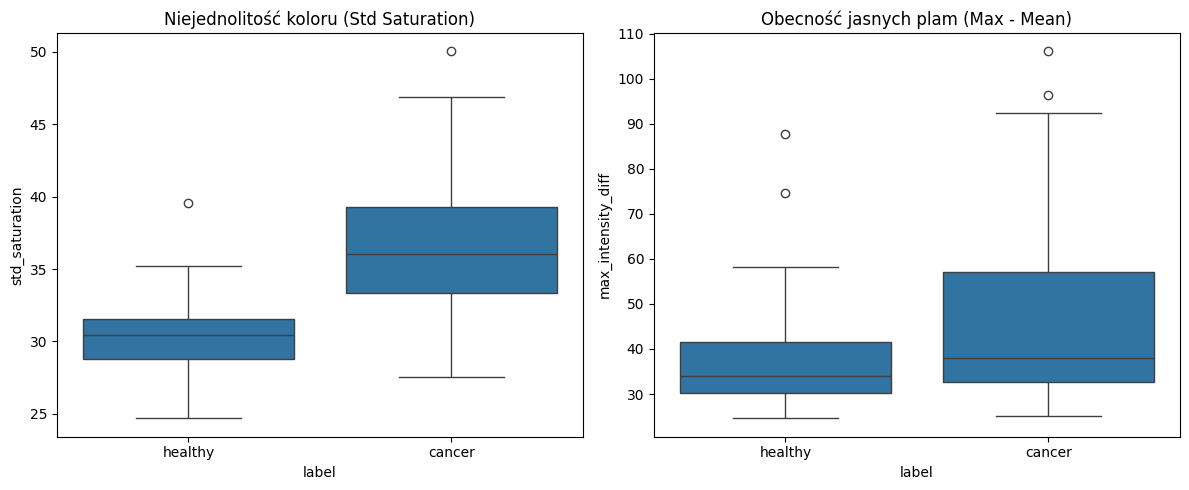

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x='label', y='std_saturation', data=df_all)
plt.title("Niejednolitość koloru (Std Saturation)")

plt.subplot(1, 2, 2)
sns.boxplot(x='label', y='max_intensity_diff', data=df_all)
plt.title("Obecność jasnych plam (Max - Mean)")

plt.tight_layout()
plt.show()

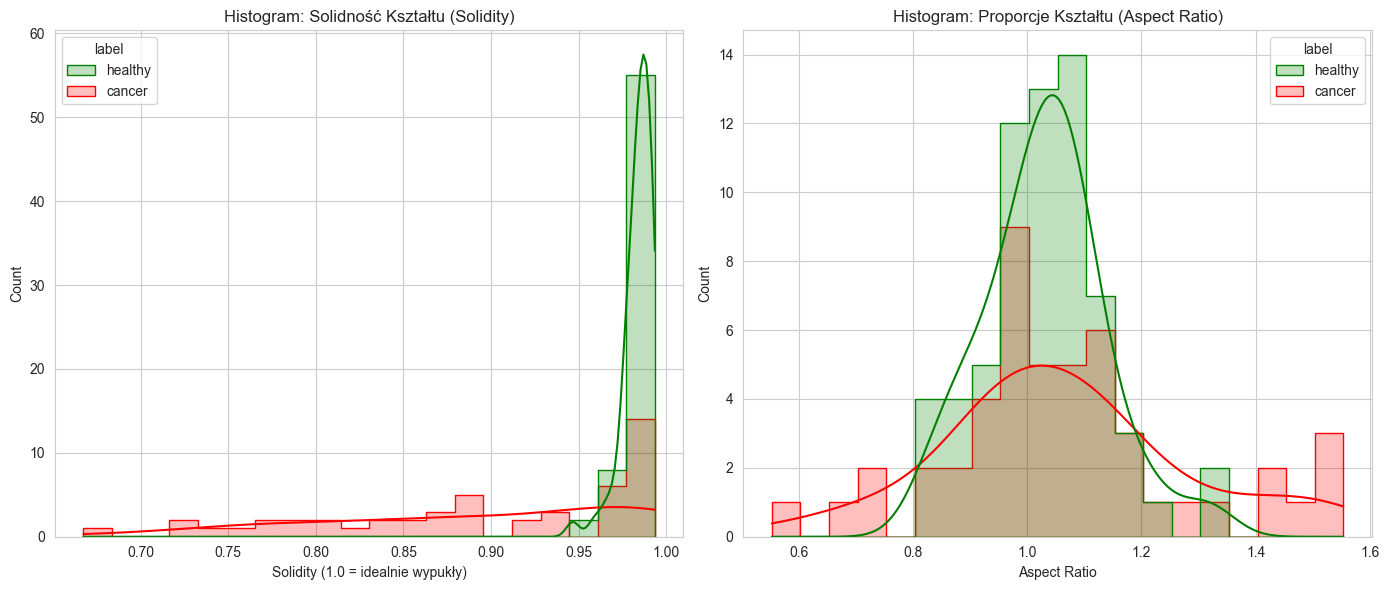

C:\Users\szymo\AppData\Local\Temp\ipykernel_20700\689589229.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='label', y='color_heterogeneity', data=df_all, palette={'healthy': 'lightgreen', 'cancer': 'salmon'})


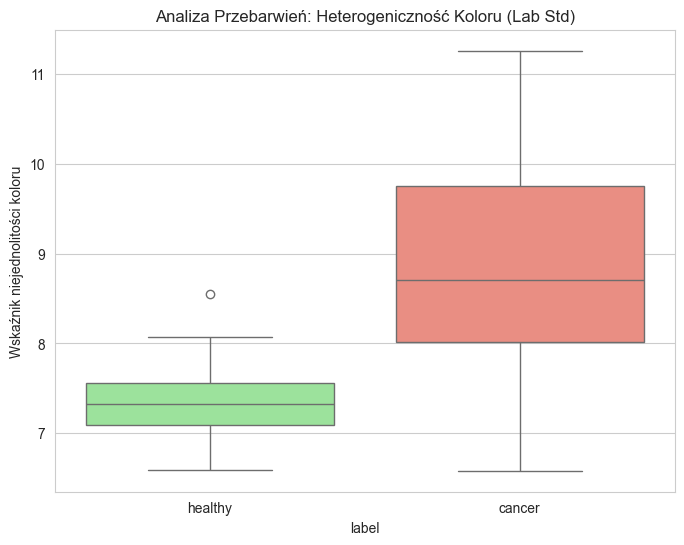

In [11]:
sns.set_style("whitegrid")
    
# Rysunek 1: Histogramy Nienaturalnego Kształtu
plt.figure(figsize=(14, 6))

# Histogram Solidity (Solidność)
# Zdrowe komórki powinny być blisko 1.0 (zwarte). Chore - szerzej rozłożone w lewo.
plt.subplot(1, 2, 1)
sns.histplot(data=df_all, x="solidity", hue="label", kde=True, element="step", bins=20, palette={'healthy': 'green', 'cancer': 'red'})
plt.title("Histogram: Solidność Kształtu (Solidity)")
plt.xlabel("Solidity (1.0 = idealnie wypukły)")

# Histogram Aspect Ratio
# Zdrowe zazwyczaj okrągłe (~1.0), chore mogą być wydłużone.
plt.subplot(1, 2, 2)
sns.histplot(data=df_all, x="aspect_ratio", hue="label", kde=True, element="step", bins=20, palette={'healthy': 'green', 'cancer': 'red'})
plt.title("Histogram: Proporcje Kształtu (Aspect Ratio)")
plt.xlabel("Aspect Ratio")

plt.tight_layout()
plt.show()

# Rysunek 2: Analiza Przebarwień (Nowa metoda LAB)
plt.figure(figsize=(8, 6))

# Wykres pudełkowy dla heterogeniczności koloru
# Wyższe wartości oznaczają większe "plamy" i różnice kolorów wewnątrz cytoplazmy/jądra
sns.boxplot(x='label', y='color_heterogeneity', data=df_all, palette={'healthy': 'lightgreen', 'cancer': 'salmon'})
plt.title("Analiza Przebarwień: Heterogeniczność Koloru (Lab Std)")
plt.ylabel("Wskaźnik niejednolitości koloru")
    
plt.show()

In [16]:
df = df_all.sample(frac=1, random_state=42).reset_index(drop=True)
split_idx = int(0.8 * len(df))
train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()


--- TRENING KLASYFIKATORA ---
Klasyfikator wytrenowany. Wzorce klas: ['cancer', 'healthy']

--- DIAGNOZOWANIE (ZBIÓR TESTOWY) ---
Szczegółowe wyniki zapisano w: output\diagnosis_results.csv

SKUTECZNOŚĆ SYSTEMU: 78.26%


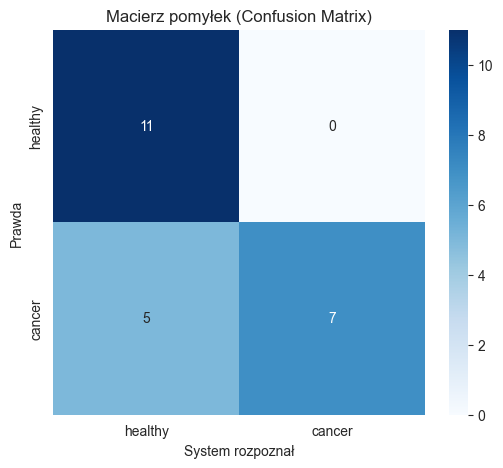


Przykładowe pomyłki (można przeanalizować wizualnie):
                filename   label predicted_label  solidity  \
93   UID_15_15_1_all.bmp  cancer         healthy  0.975947   
99   UID_15_12_1_all.bmp  cancer         healthy  0.993531   
100  UID_14_17_4_all.bmp  cancer         healthy  0.990821   
103  UID_14_13_2_all.bmp  cancer         healthy  0.967863   
111  UID_14_31_3_all.bmp  cancer         healthy  0.986928   

     color_heterogeneity  
93              7.421473  
99              9.361246  
100             8.336188  
103             7.972126  
111             6.581234  


In [21]:
# 4. Nauka Klasyfikatora (Fitting)
print("\n--- TRENING KLASYFIKATORA ---")
categories = ['healthy', 'cancer']
classifier.fit(train_df)

# 5. Rozpoznawanie (Prediction)
print("\n--- DIAGNOZOWANIE (ZBIÓR TESTOWY) ---")
predictions = classifier.predict(test_df)

# Zapisanie wyników
test_df['predicted_label'] = predictions
test_df['is_correct'] = test_df['predicted_label'] == test_df['label']

output_csv = os.path.join("output", "diagnosis_results.csv")
test_df.to_csv(output_csv, index=False)
print(f"Szczegółowe wyniki zapisano w: {output_csv}")

# 6. Ocena skuteczności
accuracy = accuracy_score(test_df['label'], predictions)
print(f"\nSKUTECZNOŚĆ SYSTEMU: {accuracy * 100:.2f}%")

# Macierz pomyłek
cm = confusion_matrix(test_df['label'], predictions, labels=categories)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('System rozpoznał')
plt.ylabel('Prawda')
plt.title('Macierz pomyłek (Confusion Matrix)')
plt.show()

# Wyświetlenie przykładów błędnych diagnoz
errors = test_df[~test_df['is_correct']]
if not errors.empty:
    print("\nPrzykładowe pomyłki (można przeanalizować wizualnie):")
    print(errors[['filename', 'label', 'predicted_label', 'solidity', 'color_heterogeneity']].head())